<a href="https://colab.research.google.com/github/akhavan12/discrete_covid_model/blob/master/Discrete_Model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from ipywidgets import GridspecLayout
from ipywidgets import FloatSlider
pd.options.display.max_rows = 999

![alt text](https://raw.githubusercontent.com/akhavan12/discrete_covid_model/master/MODEL_April_30_2020.svg)

In [0]:
## Each state represents time from onset in one conditions (E,Symp,M,W,V)
## when moving from one day to another, the states increment (E(t) -> E(t+1))
## the change or staying in each condition, and state has it's own probability

#H -- > E[ state 0, time t]--> P_E(state,E) --> + E(State 1, t+1)
#                          --> P_E(state,Symp) --> + Symp(State 0, t+1) -->(Testing ratio)
#                          --> P_H(state,H) --> + H(t+1)
#S(state=1,t) -- > M(state=0,t+1) --P_M(state=1~14,M)-- > M(state=1,t+2)
#                                 --P_M(state=1~14,W)-- > W(state=1,t+2)-----|P_W(state=1~14,V) ---> V(state=0, t=t+3) -->| P_R(state=1~14,V) --> R
#                                 --P_M(state=1~14,R)-- > R(state=1,t+2)     |P_W(state=1~14,D) --->                      | P_D(state=1~14,V) --> D
#                                                                            |P_R(state=1~14,R) ---> 
# E(state 0,  t+1) = H(t)* (M + W)*Beta/N
# H(t+1) = H(t) - E(State 0, t+1)

In [0]:
Probs={}
### M,R,Severe
Probs["M"] = [[0.8,0.00,.20], #0
          [0.80,0.00,0.20], #1
          [0.80,0.00,0.20], #2
          [0.70,0.00,0.30], #3
          [0.60,0.10,0.30], #4
          [0.50,0.10,0.40], #5
          [0.50,0.20,0.30], #6
          [0.30,0.25,0.25], #7
          [0.50,0.25,0.25], #8
          [0.50,0.25,0.25], #9
          [0.30,0.40,0.30], #10
          [0.30,0.50,0.30], #11
          [0.10,0.80,0.10], #12
          [0.05,0.95,0.00], #13
          [0.00,1.00,0.00]] #14

### Severe,R,V,D
Probs["Severe"] = [
          [0.50,0.20,0.28,0.00], #0
          [0.40,0.30,0.28,0.02], #1
          [0.40,0.30,0.28,0.02], #2
          [0.40,0.30,0.28,0.02], #3
          [0.40,0.30,0.28,0.02], #4
          [0.40,0.30,0.28,0.02], #5
          [0.50,0.30,0.18,0.02], #6
          [0.50,0.30,0.18,0.02], #7
          [0.50,0.30,0.18,0.02], #8
          [0.50,0.30,0.18,0.02], #9
          [0.50,0.30,0.18,0.02], #10
          [0.40,0.40,0.18,0.02], #11
          [0.40,0.40,0.18,0.02], #12
          [0.30,0.80,0.18,0.02], #13
          [0.00,1.00,0.00,0.00]] #14

### V,R,D 
Probs["ventilator"] = [
          [0.50,0.30,0.20], #0
          [0.40,0.30,0.30], #1
          [0.40,0.30,0.30], #2
          [0.40,0.30,0.30], #3
          [0.40,0.30,0.30], #4
          [0.40,0.30,0.30], #5
          [0.40,0.30,0.30], #6
          [0.40,0.30,0.30], #7
          [0.40,0.30,0.30], #8
          [0.40,0.30,0.30], #9
          [0.40,0.30,0.30], #10
          [0.40,0.30,0.30], #11
          [0.20,0.30,0.50], #12
          [0.20,0.30,0.50], #13
          [0.00,0.20,0.8]] #14
### Symp,M
Probs['Symp'] =[[0.50,.30], #0 Testing and + cases go to Mild cases
                [0,1], #1 ###  all remainings go to Mild cases 
         ]
### E,H,Symp
Probs["E"] = [[1.00,0.00,0.00], #0 ### first day of exposure
              [0.30,0.50,0.20], #1        
              [0.20,0.50,0.30], #2 
              [0.10,0.50,0.40], #3
              [0.05,0.45,0.50], #4
              [0.00,0.40,0.60]] #5



In [0]:
H = []
E = []
Symp = []
M = []
V = []
W = []
R = []
D = []
Beta = 0
MaxTime = 100
N=6000000



def initialize():
  global H
  global E
  global Symp
  global M
  global V
  global W
  global R
  global D
  global Beta
  global N
  global MaxTime
  global Probs

  H=np.zeros(MaxTime) ## healthy population has 1 class
  E=np.zeros([5,MaxTime]) ## Exposed population has 5 classes
  H[0]=N
  E[0,0]=100
  Beta = 1.3

  Symp=np.zeros([2,MaxTime]) ## Sympt population has 2 classes
  M=np.zeros([15,MaxTime]) ## Mild population has 14 classes
  M[0,0]=400
  Symp[0,0]=600
  V=np.zeros([15,MaxTime]) ## Ventilator population has 14 classes
  W=np.zeros([15,MaxTime]) ## Severe population has 14 classes
  R=np.zeros(MaxTime) ## Recovered population has 1 class
  D=np.zeros(MaxTime) ## Dead population has 1 class
initialize()

In [0]:
def Simulate():
  global H
  global E
  global Symp
  global M
  global V
  global W
  global R
  global D
  global Beta
  global N
  global MaxTime
  global Probs

  for t in range(MaxTime-1):
    ### transfer previous days number of recovered cases
    R[t+1] = R[t]
    D[t+1] = D[t]
  
    E[0,t+1] = np.int32(
              ( H[t] * (M[:,t].sum()+W[:,t].sum())/N)
              * Beta)
  
    if np.int32((( H[t] * (np.sum(M[:,t])+np.sum(W[:,t])))/N)* Beta)>0:
      ##print("M",M[:,t].sum())
      pass
    else:
      break
      
   ### when the case has symptoms, it is removed fromt he population
    H[t+1] = H[t]- Symp[0,t]
    
  ### at time t calculate all the values of t+1 for all the states
  
    for state in range(0,4):
      ## Stay exposed conditions
      E[state+1,t+1] =  E[state,t]*Probs["E"][state][0] 
      ## go back to healthy population
      #H[t+1] = H[t+1] + E[state,t]*Probs["E"][state][1]
      ## become symtomic
      Symp[0,t+1] = Symp[0,t+1]+ E[state,t]*Probs["E"][state][2]
    
    ### Symptomatic states 
    #################################################
    Symp[1,t+1] = Symp[0,t]*Probs["Symp"][0][0]         ### state 0 remain sympt
    M[0,t+1] =  Symp[0,t]*Probs["Symp"][0][1]           ### From state 0 to Mild state 0
    M[0,t+1] = M[0,t+1]+  Symp[1,t]*Probs["Symp"][1][1] ### From state 1 to Mild state 0
    #################################################
  
    for state in range(0,14):
      ### M,R,Severe
      M[state+1,t+1] =  M[state,t]*Probs["M"][state][0] ## from state= state --> to state+1
  
      R[t+1] = R[t+1] + M[state,t] * Probs["M"][state][1] ## from Mild to recovered
    
      W[0,t+1] = W[0,t+1]+  M[state,t] * Probs["M"][state][2]
  
    for state in range(0,14):
      ### Severe,R,V,D
      W[state+1,t+1] =  M[state,t] * Probs["Severe"][state][0]
      R[t+1] = R[t+1] + W[state,t] * Probs["Severe"][state][1]
      V[0,t+1] =  W[state,t] * Probs["Severe"][state][2]
      D[t+1] = D[t+1] + W[state,t] * Probs["Severe"][state][3]
    
    
    for state in range(0,14):
      ### V,R,D 
      V[state+1,t+1] =  V[state,t] * Probs["ventilator"][state][0]
      R[t+1] = R[t+1] + V[state,t] * Probs["Severe"][state][1]
      D[t+1] = D[t+1] + V[state,t] * Probs["Severe"][state][2]

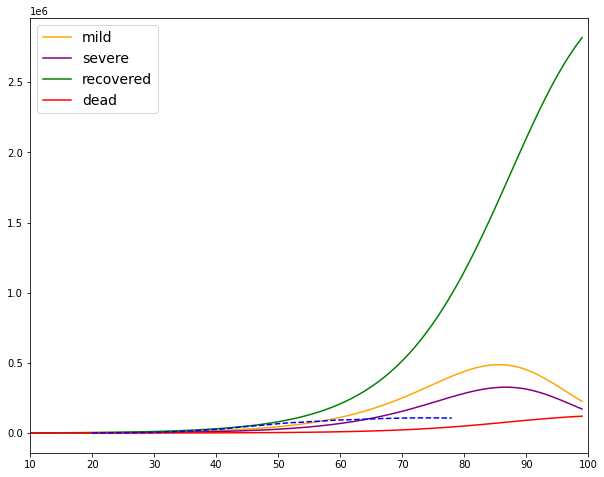

In [88]:
initialize()
Simulate()

f,ax = plt.subplots(figsize=(10,8))
ax.plot(M.sum(axis=0),color='orange',label='mild')
ax.plot(W.sum(axis=0),color='purple',label='severe')
ax.plot(R,color='green',label='recovered')
ax.plot(D,color='red',label='dead')
#ax.plot(H,color='black',label='healthy')
ax.set_xlim(xmin=10,xmax=MaxTime)
ax.legend(fontsize=14)

ax.plot(df_Italy.index+20,df_Italy['active'],'--',color='blue')

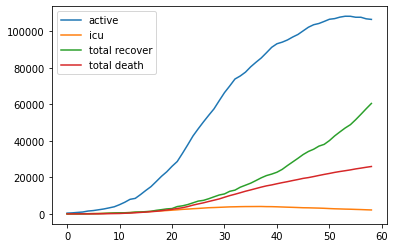

In [89]:
df_Italy = pd.read_excel('https://github.com/akhavan12/discrete_covid_model/raw/master/Country_Trends.xlsx',sheet_name='Italy')
#df_Italy[['total case','icu','total recover','total death']]
df_Italy[['active','icu','total recover','total death']].plot()

## Interactive form of the algorithm

In [0]:
step_size=.001

def Interactive_deriv()
  initialize()
  Simulate()
  f,ax = plt.subplots(figsize=(10,8))
  ax.plot(M.sum(axis=0),color='orange',label='mild')
  ax.plot(W.sum(axis=0),color='purple',label='severe')
  ax.plot(R,color='green',label='recovered')
  ax.plot(D,color='red',label='dead')
  #ax.plot(H,color='black',label='healthy')
  ax.set_xlim(xmin=10,xmax=MaxTime)
  ax.legend(fontsize=14)
  ax.plot(df_Italy.index+20,df_Italy['active'],'--',color='blue')

w = interactive(Interactive_deriv,
    e=      FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=.2, description = 'Epsilon') 
   ,B =     FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=0.21,description = 'β')  
   ,R_a =   FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=0.08,) 
   ,R_m =   FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=1) 
   ,R_w =   FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=0.86) 
   ,R_v =   FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=0.16) 
   ,G_a =   FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=0.01) 
   ,G_m   = FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=0.31)  
   ,G_w   = FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=0.07)
   ,eta_w = FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=0.2)  
   ,eta_v = FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=.8)
            ,alpha_test = FloatSlider(min=.01, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=0.4) 
  ,alpha_test_1_positive = FloatSlider(min=.1, max=1,continuous_update=False, readout_format='.3f',   step=step_size, value=0.9) )